## import libraries

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'
    
from scipy.fftpack import dct
from scipy.fftpack import idct
from scipy import io as sio 
import time
import scipy.io as sio
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
#from torchvision.datasets import CELEBA

num GPUs 1


## select dataset and set dimensionality of data

In [2]:
#mnist or celeba or cifar10
path = './data'
select_dataset = 'MNIST'
data_transform = transforms.Compose([
                transforms.Resize([64,64]),
                transforms.ToTensor()
            ])
if select_dataset == 'CIFAR10':
    train_dataset = CIFAR10(os.path.join(path, 'datasets', 'cifar10'), train=True, download=True,
                      transform=data_transform)
    test_dataset = CIFAR10(os.path.join(path, 'datasets', 'cifar10_test'), train=False, download=True,
                           transform=data_transform)
elif select_dataset == 'MNIST':
    train_dataset = MNIST(os.path.join(path, 'datasets', 'mnist'), train=True, download=True,
                    transform=data_transform)
    test_dataset = MNIST(os.path.join(path, 'datasets', 'mnist_test'), train=False, download=True,
                         transform=data_transform)
elif select_dataset == 'CELEBA':
    train_dataset = CelebA(root=os.path.join(path, 'datasets', 'celeba'), split='train',
                     transform=transforms.Compose([
                         transforms.CenterCrop(140),
                         transforms.Resize(
                             [64,64]),
                         transforms.ToTensor(),
                     ]), download=True)
    test_dataset = CelebA(root=os.path.join(path, 'datasets', 'celeba_test'), split='test',
                                  transform=transforms.Compose([
                                      transforms.CenterCrop(140),
                                      transforms.Resize(
                                         [64,64]),
                                      transforms.ToTensor(),
                                  ]), download=True)

In [3]:
x = train_dataset.train_data[3]


/data/gauri/venv/lib/python3.6/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


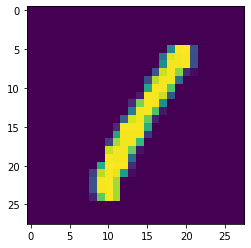

In [4]:
plt.imshow(x[:,:])

In [5]:
d = x.nelement()
n = int(1*d)

In [6]:
d

784

## generate measurement matrix A and fix it

In [7]:
#A
A = torch.tensor(np.random.randn(n,d))

In [8]:
x = x.type(dtype=torch.double)

In [9]:
xvec = x.view(-1,1)

## generate measurements as a forward operation

In [10]:
#def forwardA
def forwardA(x,A):
    return torch.matmul(A,x.view(-1,1).type(dtype=torch.double))

In [11]:
#select x and generate y=Ax
y = forwardA(x,A)

## load generator pre-trained network

In [29]:
#G
from dcgan import Generator

G = Generator(ngpu=1).eval()

# load weights
G.load_state_dict(torch.load('netG_epoch_99.pth'))
if torch.cuda.is_available():
    G = G.cuda()

In [30]:
G

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)

## select optimizer, loss function, freeze weights of G and only optimize over z

In [25]:
batch_size = 1
latent_size = 100
z = Variable(torch.randn(batch_size,latent_size,1,1).cuda(), requires_grad=True)
z.data = z.data 
optim = torch.optim.SGD([z],lr=0.1)
#loss
loss = torch.nn.MSELoss()

In [26]:
z.requires_grad

True

## sample zhat such that zhat = argmax p(z), s.t. AG(z) = y

In [27]:
#use Langevin dynamics
step_lr = 0.001
loss_cum = []
for i in range(10000):
    optim.zero_grad()
    yhat = forwardA(G(z),A.to('cuda'))
    mseloss = loss(yhat,y.to('cuda'))
    loss_cum.append(mseloss.item())
    mseloss.backward()
    optim.step()
    if i > 1000 and loss_cum[-1] > loss_cum[-2]:
        break
    noise = torch.randn_like(z) * np.sqrt(step_lr * 2)
    grad = z.grad
    with torch.no_grad():
        z -=  step_lr * grad - noise

## reconstruct xhat = G(zhat)

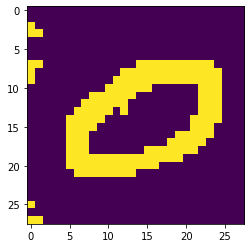

In [28]:
#plot reconstruction xhat vs x and compute reconstruction error
xhat = G(z).cpu().detach()
plt.imshow(xhat[0,0,:,:])
mse = loss(xhat,x)

In [24]:
print(mse)

tensor(4824.8253, dtype=torch.float64)


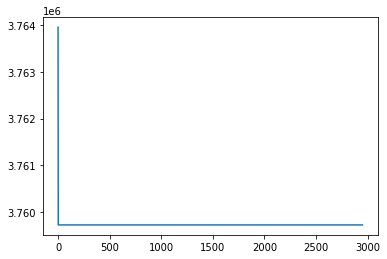

In [19]:
plt.plot(loss_cum)